# PyNX Simulation of Pt NP (Clement)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.append('/data/id01/inhouse/corentin/python/')
import utils.simutils as su
import utils.parsutils as pu
import utils.plutils as plu
import colorcet
import importlib
from numpy.fft import fftn, fftshift, ifftn, ifftshift
sys.path.append('/data/id01/inhouse/clatlan/pythonies/cdiutils')
from cdiutils.utils import make_support, nan_to_zero, zero_to_nan, center, crop_at_center, normalize
from cdiutils.plot.plot import plot_slice, plot_3D_volume_slices
from cdiutils.postprocessing.phase import hybrid_gradient
from skimage.restoration import unwrap_phase

In [ ]:
importlib.reload(su)
importlib.reload(pu)
importlib.reload(plu)

In [3]:
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1.5

# Initialize parameters

In [13]:
div = 10
lattice = 3.94196
nstep = 200
n = nx, ny, nz = 128, 128, 128
# hkl, hklstr = [0,0,2], '002' # Reflections to compute
hkl, hklstr = [0,2,0], '020' # Reflections to compute
# hkl, hklstr = [2,0,0], '200' # Reflections to compute
vmin, vmax = 8, 14
version = 'nanosculpt'
final_shape = (64, 64, 64)
phase_range = np.pi/4
strain_range = 0.002

# Euler angle for rotation

In [64]:
qexp = [-0.22555994922966777, 3.1952281466819685, 0.11476348017971627]
qexp = [-0.22541559054755156, 3.1952281466819685, 0.11504676708864547]

In [65]:
M = su.rotarray_v1v2([0,1,0], qexp)

theta = -np.arcsin(M[3-1,1-1])

psi = np.arctan2(M[3-1,2-1]/np.cos(theta), 
                 M[3-1,3-1]/np.cos(theta))

phi = np.arctan2(M[2-1,1-1]/np.cos(theta), 
                 M[1-1,1-1]/np.cos(theta))

In [63]:
print(np.rad2deg(phi), np.rad2deg(theta), np.rad2deg(psi))

4.035377906510912 -0.07229648540411411 2.051916392247523


In [66]:
print(np.rad2deg(phi), np.rad2deg(theta), np.rad2deg(psi))

4.032790996026037 -0.0724285610355806 2.056983607842733


# Compute Fhkl

In [14]:
path = f'/data/id01/inhouse/corentin/lammps/Pt/nanosculpt/div{div}_oriented_v2.5/'
np_file_xyz = f'NP_Pt_nanosculpt_div{div}_oriented_v2.5_minimized.xyz'
name = f'NP_Pt_nanosculpt_div{div}_oriented_v2.5_minimized'

In [15]:
# Parse the atomic positions
pos_Pt = x, y, z = pu.read_Pt_xyz(path + np_file_xyz)
# r_z = su.rotarray_vtheta([1,0,0], np.deg2rad(90))
r_z = su.rotarray_vtheta([1,0,0], np.deg2rad(0))
pos_Pt = r_z.dot(pos_Pt)

In [16]:
# Compute scattering
qx, qy, qz, fhkl, intensity = su.compute_scat_Pt(hkl, lattice, nstep, n, pos_Pt, hklstr, name, save_data=False)

/data/id01/inhouse/corentin/python/utils/plutils.py:966: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


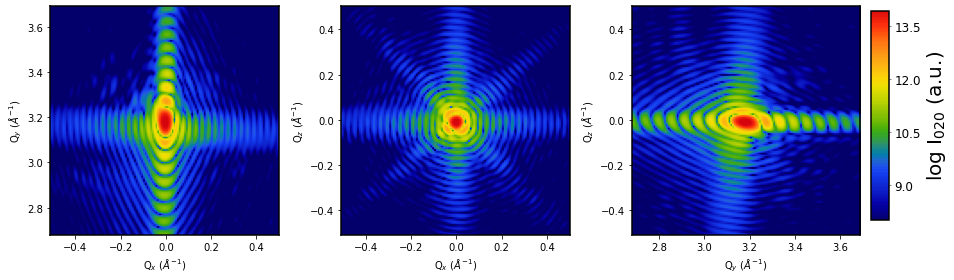

In [17]:
# Plotting the bragg peak
plu.plot_bragg(hklstr, intensity, qx, qy, qz, vmin, vmax, name, nstep, True, cmap='cet_CET_R4')

In [18]:
# Lattice param of max intensity, to check if it's centered
q_max = su.a_equi(hklstr, intensity, qx, qy, qz, printtag=True)

hkl : 020
Intensity shape : (128, 128, 128)
x [64] y [64] x [64] z [64] y [64] z [64]
Qmax 0.0 3.188 0.0
d-spacing = 1.97098 A  --> a (equivalent) = 3.94196 A


In [19]:
def plot_pos(pos, size_box=200, thickness=1, size=1, figsize=(9,3)):
    fig, ax = plt.subplots()
    plt.subplot(131)
    plt.scatter(pos_Pt[2][abs(pos_Pt[0][:]) < thickness], pos_Pt[1][abs(pos_Pt[0][:]) < thickness], s=size)
    plt.scatter([-size_box, size_box], [-size_box, size_box], s=0)
    plt.axis('equal'); plt.xlabel('Z'); plt.ylabel('Y')
    plt.subplot(132)
    plt.scatter(pos_Pt[2][abs(pos_Pt[1][:]) < thickness], pos_Pt[0][abs(pos_Pt[1][:]) < thickness], s=size)
    plt.scatter([-size_box, size_box], [-size_box, size_box], s=0)
    plt.axis('equal'); plt.xlabel('Z'); plt.ylabel('X'); plt.yticks([])
    plt.subplot(133)
    plt.scatter(pos_Pt[1][abs(pos_Pt[2][:]) < thickness], pos_Pt[0][abs(pos_Pt[2][:]) < thickness], s=size)
    plt.scatter([-size_box, size_box], [-size_box, size_box], s=0)
    plt.axis('equal'); plt.xlabel('Y'); plt.ylabel('X'); plt.yticks([])
#     plt.tight_layout()
    fig.set_size_inches(figsize)
    return None

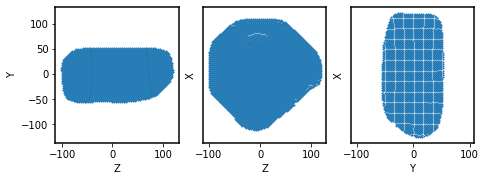

In [20]:
plot_pos(pos_Pt, size_box=40, thickness=1, size=1, figsize=(7.5,2.5))

In [22]:
np.savez_compressed(f'Fhkl_{name}_{hklstr}_nstep_{nstep}_oriented_v2.5.npz', fhkl=fhkl)

# Load Ratio 1:10 Fhkl data

# Exp data

In [118]:
filename = '/data/id01/inhouse/clatlan/experiments/ihhc3567/analysis/results/S182/pynxraw/'\
            'S182_amp-disp-strain_0.65_mode_avg3_apodize_blackman_crystal-frame.npz'

In [119]:
data_exp = np.load(filename)

In [120]:
disp_exp = data_exp['displacement']
support_exp = make_support(normalize(data_exp['amp']), isosurface=0.5, nan_value=True)
nx, ny, nz = disp_exp.shape
sizecrop = 32
disp_exp_crop = disp_exp[nx//2-sizecrop:nx//2+sizecrop, ny//2-sizecrop:ny//2+sizecrop, nz//2-sizecrop:nz//2+sizecrop]
support_exp_crop = support_exp[nx//2-sizecrop:nx//2+sizecrop, ny//2-sizecrop:ny//2+sizecrop, nz//2-sizecrop:nz//2+sizecrop]

voxel_size = np.array([5,5,5])

qnorm = 3.2
_, strain_020_exp, _ = hybrid_gradient(disp_exp_crop/qnorm, 
                                                     voxel_size[0]*10, 
                                                     voxel_size[1]*10, 
                                                     voxel_size[2]*10)


# Determine the phase and strain

In [23]:
obj = fftshift(fftn(fftshift(np.conj(fhkl))))
# obj = fftshift(fftn(fftshift(np.conj(fhkl_centered))))
# final_shape = (128, 128, 128)
isosurface = 0.5
amp = abs(obj)
phase = np.angle(obj)

amp, center_amp = center(amp, verbose=False, return_former_center=True)
amp = crop_at_center(amp, final_shape=final_shape)
normalized_amplitude = normalize(amp, zero_centered=False)

support = make_support(normalized_amplitude, isosurface=isosurface, nan_value=True)

phase = center(phase, center_coordinates=center_amp)
phase = crop_at_center(phase, final_shape=final_shape)

mask = np.where(np.isnan(support), 1, 0)
masked_phase = np.ma.masked_array(phase, mask=mask)

unwrapped_phase = unwrap_phase(masked_phase, wrap_around=False, seed=1).data
no_ramp_phase, ramp = su.remove_phase_ramp(unwrapped_phase * support, return_ramp=True)
zero_origin_phase = no_ramp_phase - np.nanmean(no_ramp_phase * support)

new_obj = amp * np.exp(1j * nan_to_zero(zero_origin_phase))
fft_new_obj = fftshift(fftn(fftshift(new_obj)))
fft_new_obj = fft_new_obj * su.blackman_window(new_obj.shape)
re_new_obj = fftshift(ifftn(fftshift(fft_new_obj)))

amp_clean = normalize(np.abs(re_new_obj), zero_centered=False)
support_clean = make_support(amp_clean, isosurface=isosurface, nan_value=True)
phase_clean = np.angle(re_new_obj)*support_clean


dqx = qx.max() - qx.min()
dqy = qy.max() - qy.min()
dqz = qz.max() - qz.min()

voxel_size = 2*np.pi/10*np.array([1/dqx, 1/dqy, 1/dqz])

qnorm = su.norm(q_max)
strain_200, strain_020, strain_002 = hybrid_gradient(phase_clean/qnorm, 
                                                     voxel_size[0]*10, 
                                                     voxel_size[1]*10, 
                                                     voxel_size[2]*10)

/data/id01/inhouse/clatlan/pythonies/cdiutils/cdiutils/postprocessing/phase.py:125: RuntimeWarning: Mean of empty slice
  grad_x = np.nanmean([grad_x[1:], grad_x[:-1]], axis=0)
/data/id01/inhouse/clatlan/pythonies/cdiutils/cdiutils/postprocessing/phase.py:126: RuntimeWarning: Mean of empty slice
  grad_y = np.nanmean([grad_y[: ,1:, :], grad_y[:, :-1, :]], axis=0)
/data/id01/inhouse/clatlan/pythonies/cdiutils/cdiutils/postprocessing/phase.py:127: RuntimeWarning: Mean of empty slice
  grad_z = np.nanmean([grad_z[..., 1:], grad_z[..., :-1]], axis=0)


# Plot and save the figures

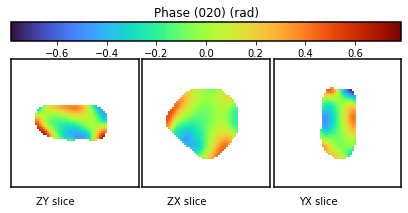

In [24]:
fig_phase = plot_3D_volume_slices(
#     np.flip(ramp,axis=2),
#     np.flip(zero_origin_phase,axis=2),
#     np.flip(np.angle(re_new_obj),axis=2),
    np.flip(np.angle(re_new_obj)*support_clean,axis=2), 
#     np.flip(amp_clean,axis=2),
    show_cbar=True,
#     vmin=-np.pi, vmax=np.pi, 
    vmin=-phase_range, vmax=phase_range, 
    figsize=(7,7),
    data_stacking='vertical', cbar_title = f'Phase ({hklstr}) (rad)', 
#     titles=[f'Ratio 1:{div}, ramp', f'Ratio 1:{div}, before apo', f'Ratio 1:{div}, after apo', 'clean'], 
    return_fig=True
)

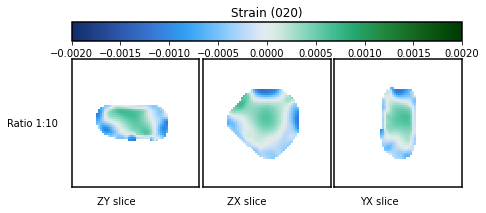

In [25]:
fig_strain = plot_3D_volume_slices(
    np.flip(strain_020,axis=2), show_cbar=True, cmap='cet_CET_D13',
    vmin=-strain_range, vmax=strain_range, figsize=(7,7), 
    data_stacking='vertical', cbar_title = f'Strain ({hklstr})',
    titles=[f'Ratio 1:{div}'], return_fig=True
)

In [26]:
fig_phase.savefig(f'{name}_phase_{hklstr}_nstep_{nstep}_oriented_v2.5.png', dpi=300)
# fig_phase_exp.savefig(f'S182_exp_phase_{hklstr}.png', dpi=300)
# fig_strain_exp.savefig(f'S182_exp_strain_{hklstr}.png', dpi=300)
fig_strain.savefig(f'{name}_strain_{hklstr}_nstep_{nstep}_iso_{isosurface}_oriented_v2.5.png', dpi=300)

# Export to VTI for ParaView visualization

In [27]:
su.save_to_vti_coco(
    f'MD_div{div}_v{version}_hkl_{hklstr}_nstep_{nstep}_iso_{isosurface}_oriented_v2.5.vti', 
    voxel_size,  
    [np.flip(amp_clean,axis=2),
     np.flip(nan_to_zero(np.angle(re_new_obj)),axis=2), 
     np.flip(nan_to_zero(np.angle(re_new_obj))/qnorm,axis=2), 
     np.flip(nan_to_zero(strain_020), axis=2)],
    ['amplitude', 'phase', 'displacement','strain']
)

In [28]:
name

'NP_Pt_nanosculpt_div10_oriented_v2.5_minimized'

In [29]:
hklstr

'020'